# Un problème $np-$difficile classique en IA : $k-$center

Soit $n$ villes, on cherche à installer $k$ casernes de pompiers de façon à ce qu'une intervention soit possible rapidement dans chaque ville. Pour chaque ville, la durée d'intervention minimale est dépendante de la caserne de pompier la plus proche. Dans notre cas, on considère la durée d'intervention minimale pour toutes les villes, et on prend comme critère la pire durée d'intervention parmi toutes celles-ci. L'idée est d'avoir une "pire durée d'intervention" qui soit la plus petite possible.
Voici le problème des $k-$centers appliqué à un problème du réel.

Dans le cas général, considère $n$ points de données $X=\lbrace x_1, x_2, \cdots, x_n\rbrace$. On cherche à trouver $k$ centres $M=\lbrace \mu_1, \mu_2, \cdots, \mu_k\rbrace$ parmi ces $n$ données tels que ces centres minimisent la distance maximale qui existe parmi tous les points entre chaque point et son centre le plus proche.

Ce problème d'optimisation est $NP-$difficile. Les problèmes $NP-$difficiles sont des problèmes qui sont au moins aussi difficiles que tous les problèmes de la classe $NP$, comme les problèmes $NP-$complets. En revanche, les problèmes $NP-$difficiles ne sont pas forcément dans $NP$.
Dans le cas d'un tel problème d'optimisation, le fait de *vérifier* que la solution est optimale revient à *calculer* la solution optimale, ce qui ne se fait pas en temps polynomial.
Ainsi, si tous les problèmes $NP-$complets sont $NP-$difficiles (ils sont au moins aussi difficiles que tous les problèmes de $NP$), tous les problèmes $NP-$difficiles ne sont pas dans $NP$, et peuvent donc être plus difficiles à résoudre.

La résolution des $k-$centers ou de problèmes proches peut permettre : 
- de trouver un ensemble de sommets dominant le graphe
- de détecter des communautés d'un graphe
- de rassembler des documents ayant le même thème dans une collection de documents
- de rassembler des molécules ayant des propriétés semblables dans une base de données
- etc.

Nous allons chercher à résoudre le problème des $k-$centers : 
1. d'abord de façon optimale via un algorithme exact testant toutes les combinaisons de centres possibles, mais avec $n$ et $k$ de petites tailles.
2. puis via une première heuristique gloutonne de distance maximale au dernier centre trouvé
3. via une seconde heuristique gloutonne de distance maximale à tous les centres trouvés
4. enfin, via un algorithme de recherche locale stochastique proche de celui des $k-$médoïdes qui est un algorithme classique de la famille des algorithmes d'apprentissage supervisé en IA. 


Les fonctions suivantes permettent de générer des données aléatoirement, et d'afficher ces données en utilisant matplotlib.

In [50]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt

def generate_data(n : int =100, k : int =3):
    '''
    n : le nombre de données à générer
    k : le nombre de groupes à créer dans l'espace, plus k augmente, plus il est difficile de trouver des 
    centres convenables
    returns : une liste de liste. La première liste est de taille n, elle contient les n données
    générées. Chaque élément de cette liste est une liste de taille 2 décrivant deux coordonnées
    dans le plan : [[x11, x12], [x21, x22], ..., [xn1, xn2]]
    '''
    X, _ = make_blobs(n_samples=n, centers=k, n_features=2)
    res = list()
    for x in X:
        res.append(list(x))
    return res

from scipy.spatial.distance import euclidean
from math import inf
    
def plot_data(X, centers, title: str=""):
    '''
    X : les données sous forme de liste de liste
    centers : les centres identifiés, sous forme de liste de liste
    '''
    def closest(x, centers):
        dist = inf
        mini = -1
        for idx, center in enumerate(centers):
            d = euclidean(x,center)
            if d < dist:
                dist = d
                mini = idx
        return mini

    plt.figure()
    
    lw = 2    
    nb_centers = len(centers)       

    colors = ["b", "g", "r", "c", "m", "y", "k"]
    while len(colors) < nb_centers:
        colors += colors   
    color_list = colors[:nb_centers]
    y = [closest(i, centers) for i in X]
    colors = [color_list[i] for i in y]

    for x,color in zip(X,colors):
        center = x in centers
        size = 50 if center else 5
        marker = 'v' if center else 'o'
        alpha = 0.8 if center else 0.4
        plt.scatter(
            x[0], x[1], color=color, alpha=alpha, lw=lw, s = size, marker=marker
        )
    plt.title(title)
    plt.show()

**Exemple d'utilisation**
- Les centres sont affichés via des triangles de plus grande taille
- Chaque point de donnée est affecté à son centre le plus proche et a donc la même couleur
- Pour mesurer la proximité entre un centre et une donnée, on utilise la distance euclidienne avec `from scipy.spatial.distance import euclidean`

Rien à faire ci-dessous, juste à observer les résultats.

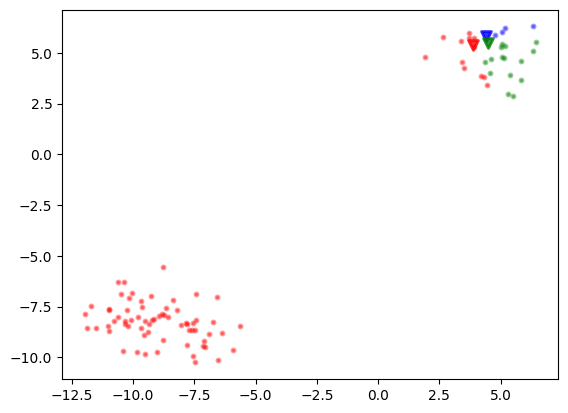

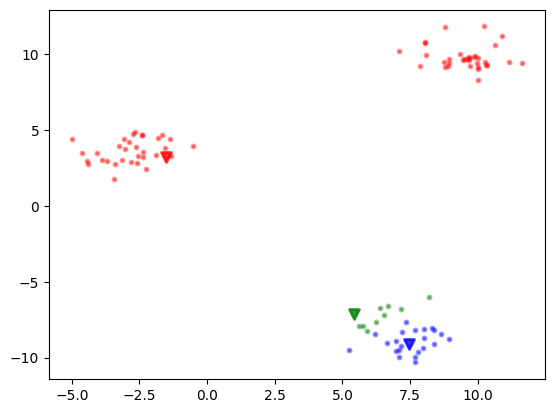

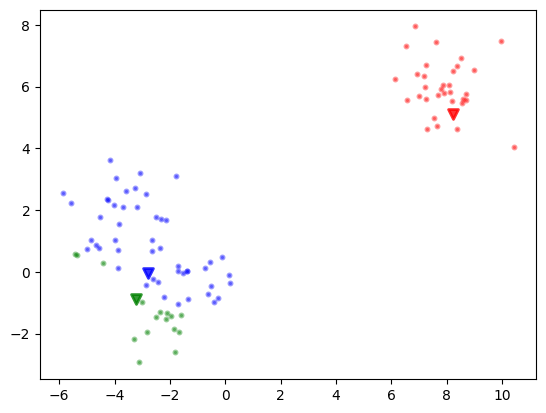

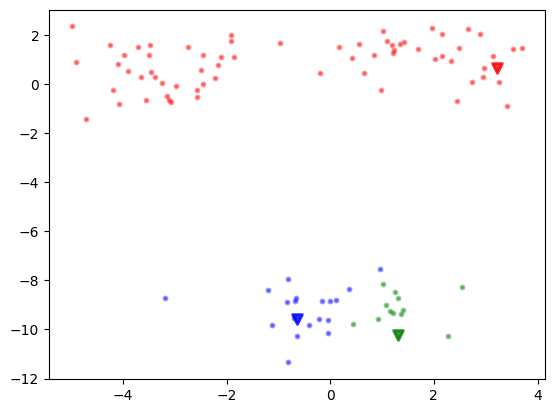

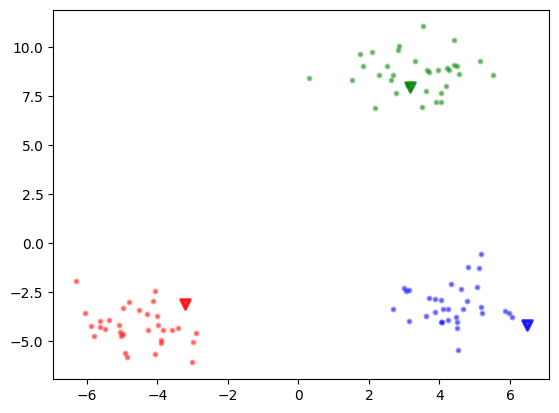

In [51]:
for i in range(5):
    X = generate_data(100)
    # Je choisis 3 centres en prenant les trois premiers points dans X
    plot_data(X, X[:3])

## 1. Trouver des centres aléatoirement

Implémenter une méthode qui renvoie $k$ centres piochés aléatoirement (sans remise) dans $X$ et tester votre méthode.

In [52]:
import random
def get_random_centers(X:list, k : int =3):
    return random.sample(X,k)


In [53]:
X = generate_data(100)
get_random_centers(X,3)

[[-1.5094075799335123, 6.5627945861050385],
 [-1.2680568560939705, 4.819103090175499],
 [-2.258537208581256, 3.381728324857904]]

## 2. Calculer le score

Ce que nous appelons le *score* ici, c'est la fonction qui va calculer la qualité de la solution trouvée par nos algorithmes. Il s'agit donc de la distance maximale parmi tous les distances entre un point et son centre le plus proche. **Ainsi, plus le score est élevé, moins les centres sont bons !**
Les fonctions `min` et `max` existent pas défaut dans Python. Et pour calculer une distance entre deux points, vous pouvez utiliser `euclidean(a,b)`.

In [63]:
def centre_plus_proche(x,centers):
    proche_c = None
    proche_d = inf
    
    for c in centers:
        d=euclidean(x,c)
        if d < proche_d:
            proche_d = d
            proche_c = c
            
    return proche_c,proche_d

def score(X:list, centers: list):
    maximum= -inf
    for x in X:
        _,d=centre_plus_proche(x,centers)
        maximum=max(maximum,d)
    return maximum


-inf

**Vous pouvez utiliser le code ci-dessous pour tester votre méthode et voir si vos résultats sont cohérents**

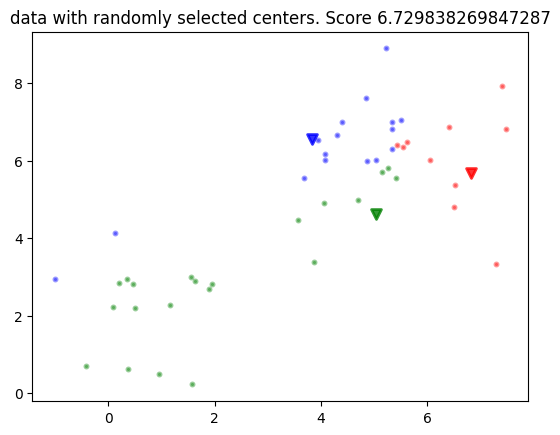

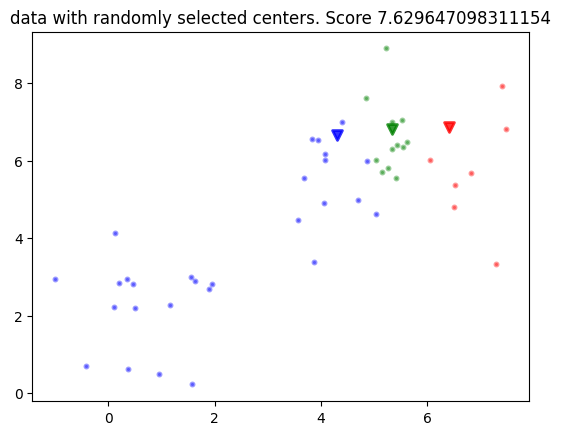

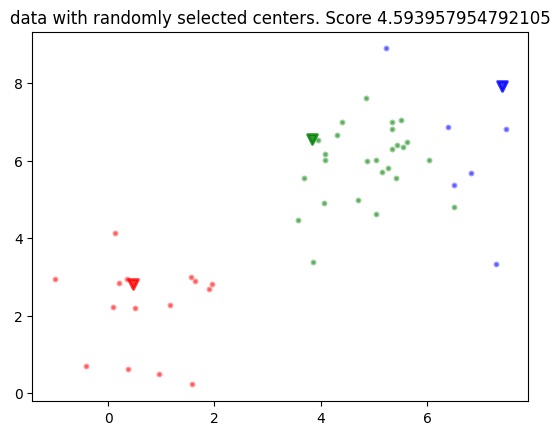

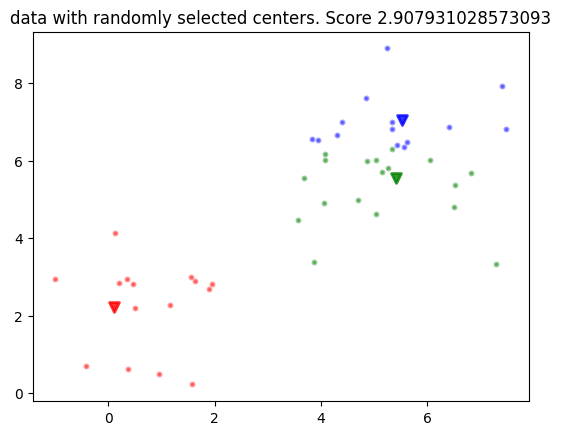

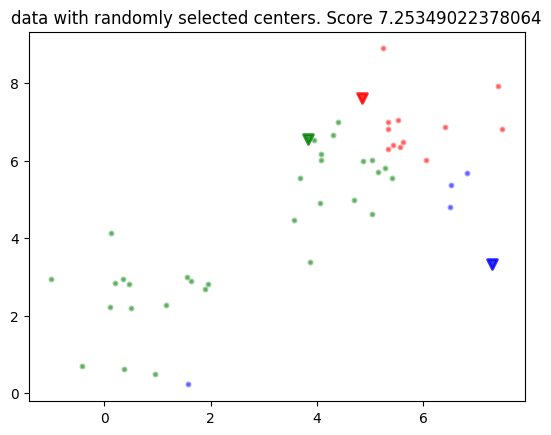

In [67]:
X = generate_data(50)
for i in range(5):
    centers = get_random_centers(X)
    plot_data(X, centers, title = f'data with randomly selected centers. Score {score(X, centers)}') 

## 3. Algorithme exact

### 3.1. Implémentation

Implémentez ci-dessous l'algorithme exact. Celui-ci calcule tous les sous-ensembles de taille $k$ piochés parmi $X$, soit tous les centres possibles. Pour chaque sous-ensemble, l'algo calcule son *score* avec la fonction que vous avez implémentée. L'algo conserve les centres pour lesquels le score est minimal (plus le score est élevé, moins les centres sont bien choisis).

In [103]:
import itertools
def algo_exact(X: list, k:int=3):
    best_centers=None
    best_score=inf
    for candidate in itertools.combinations(X,k):
        score_ = score(X,candidate)
        if score_<best_score:
            best_centers=candidate
            best_score=score_
            
    return best_centers


**Vous pouvez tester votre algo avec le code ci-dessous**

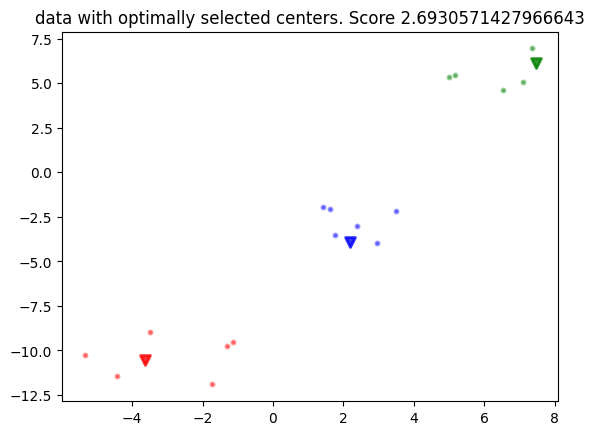

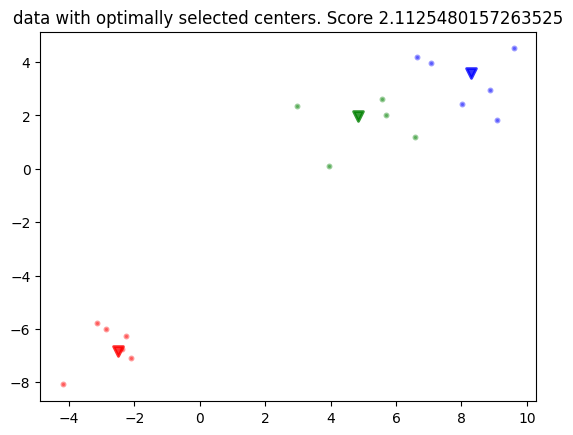

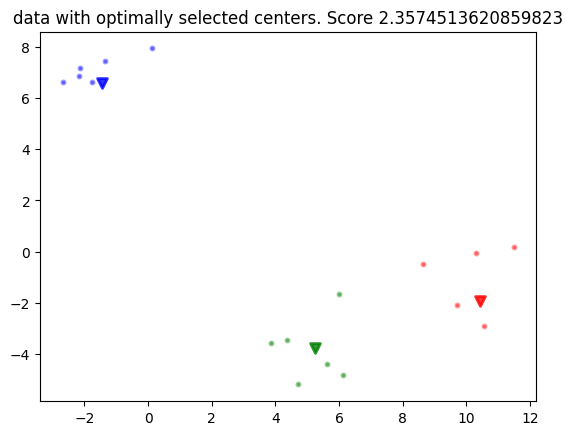

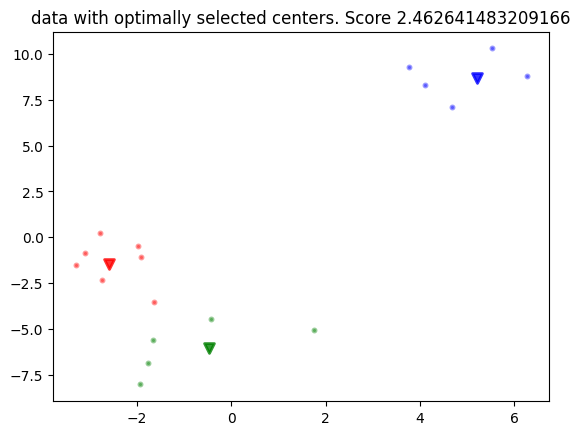

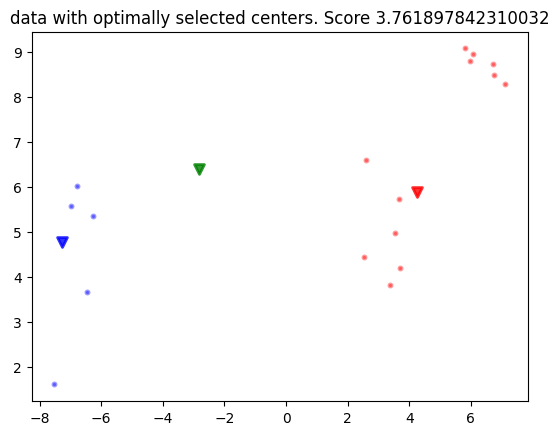

In [104]:
for i in range(5):
    X = generate_data(20)
    centers = algo_exact(X)
    plot_data(X, centers, title = f'data with optimally selected centers. Score {score(X, centers)}') 

### 3.2. Mesurer le temps d'exécution de l'algorithme exact

Pour mesurer le temps d'exécution de l'algorithme exact, vous pouvez faire varier le nombre de vos données de 10 à 26 par pallier de 5 (`list(range(10,26, 5))`), et le valeur de $k$ de 2 à 5.
Qu'observez-vous ?

In [ ]:
import time
ks = list(range(2,6))
ns = list(range(10,26, 5))

#TODO


## 4. Heuristiques gloutonnes

### 4.1. le prochain centre est le centre le plus loin du dernier centre choisi

L'algorithme choisit d'abord un centre aléatoirement dans $X_{copy}$ et le supprime de $X_{copy}$. Puis, tant que $k$ centres n'ont pas été choisis, on va calculer la distance de tous les points de $X_{copy}$ au dernier centre choisi (`euclidean(x,centers[-1])`). On ajoute aux centres celui qui en est le plus loin. Et on le supprime de $X_{copy}$.

In [115]:
def greedy_kcenter_farthest_previous(X, k=3):
    X_copy = X.copy()
    idx=np.random.randint(0,len(X))
    centers=[X_copy[idx]]
    del X_copy[idx]
    while len(centers) < k:
        dist_max= -inf
        id_max= None 
        for i,x in enumerate(X_copy):
            dist=euclidean(x, centers[-1])
            if dist > dist_max:
                dist_max=dist
                id_max=i
        centers.append(X_copy[id_max])
    del X_copy[id_max]
        
    return centers

**Vous pouvez tester votre code avec la cellule suivante**

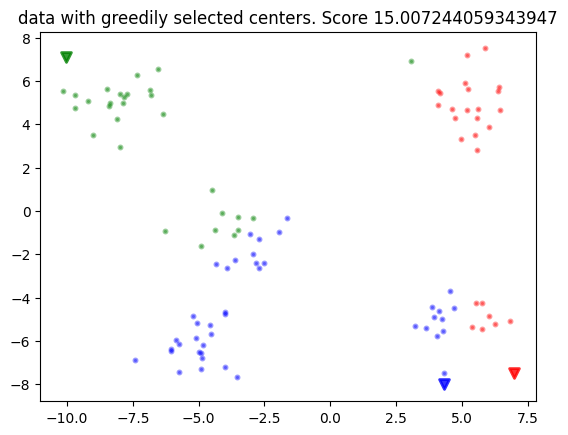

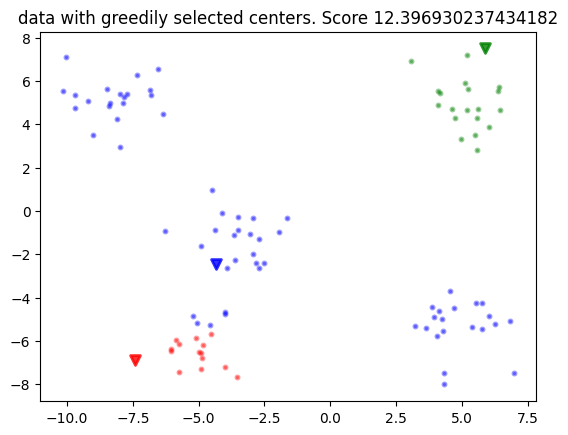

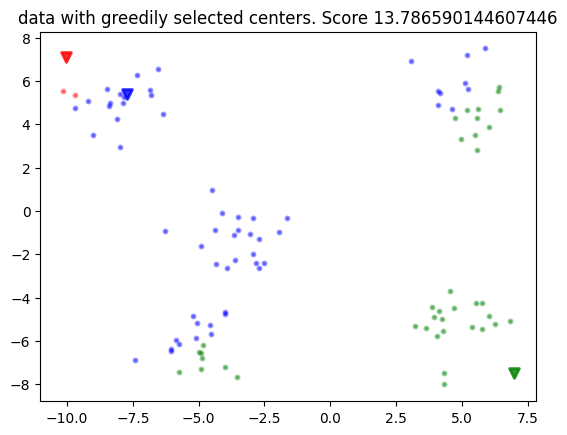

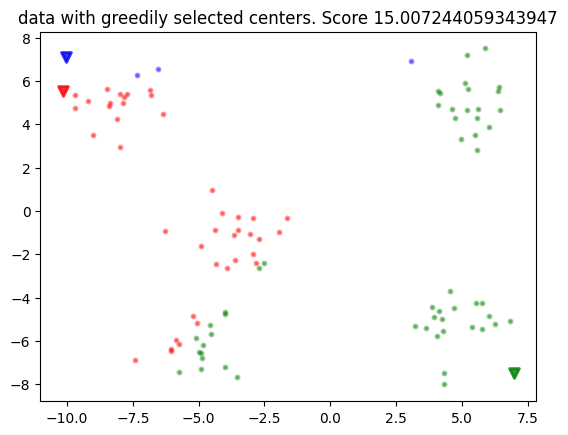

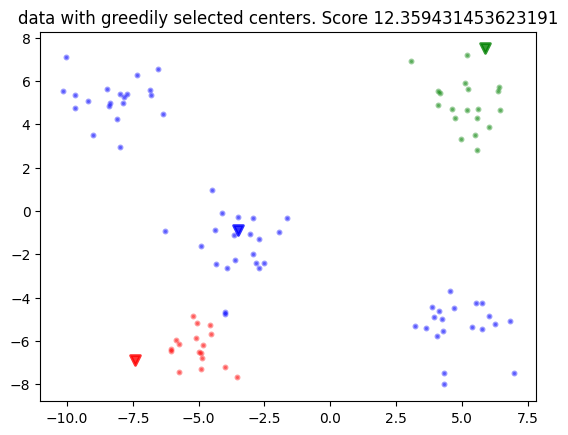

In [116]:
X = generate_data(100, k=5)
for i in range(5):
    centers = greedy_kcenter_farthest_previous(X, k=5)
    plot_data(X, centers, title = f'data with greedily selected centers. Score {score(X, centers)}') 

### 4.2. le prochain centre est le centre le plus loin de tous les centres choisis

Cette heuristique est décrite dans le cours page 28.

L'algorithme choisit d'abord un centre aléatoirement dans $X_{copy}$ et le supprime de $X_{copy}$. Puis, tant que $k$ centres n'ont pas été choisis, on va calculer la distance de tous les points de $X_{copy}$ à tous les centres choisis. On ajoute aux centres celui qui en est le plus loin, i.e. dont la somme des distances à tous les centres est maximale. Et on le supprime de $X_{copy}$.

In [11]:
def greedy_kcenter_farthest_all(X, k=3):
    X_copy = X.copy()
    

**Vous pouvez tester votre code avec la cellule ci-dessous**

In [ ]:
for i in range(5):
    centers = greedy_kcenter_farthest_all(X, k=5)
    plot_data(X, centers, title = f'data with greedily selected centers. Score {score(X, centers)}') 

**Qu'observez-vous quant à la qualité des solutions données par ces heuristiques gloutonnes ?**

## 5. Stochastic local seach : variante des $k-$médoïdes

Cet algorithme fonctionne différemment des précédentes. Par *stochastic*, on entend un processus algorithmique dans lequel l'aléatoire entre en jeu, et par *local search*, on signifie que l'on va chercher *localement* à améliorer une solution candidate. Dans ce contexte, *localement* signifie que l'on va apporter des modifications très légères à notre solution candidate, et donc en rester proche dans l'espace de recherche : à chaque étape, on va essayer de supprimer un centre de cette solution et d'en ajouter un autre qui améliore le *score*.

L'algorithme fonctionne ainsi : 
1. Initialisation de $k$ centres aléatoirement (utiliser votre fonction ` get_random_centers(X, k)`)
2. Calcul du score de référence.
Itérer `max_iter` fois : 
3. Choisir un point *candidat* parmi $X$ aléatoirement
4. Essayer de remplacer chaque centre par le point *candidat*, puis calculer le score. Si un gain en score est observé en cas de remplacement d'un centre par *candidat*, alors *candidat* remplace le centre et le score de référence à améliorer est mis à jour.

In [119]:
def k_medoids(X, k=3, max_iter=100):
    centers = get_random_centers(X, k)
    score_ref = score(X,centers)
    
    for i in range(max_iter):
        candidat=np.random.randint(0,len(X))
        for j in range (k):
            centers_copy=centers.copy()
            candidat_score= score(X, centers_copy)
            if candidat_score < score_ref:
                candidat_score =score_ref
                centers= centers_copy
    return centers

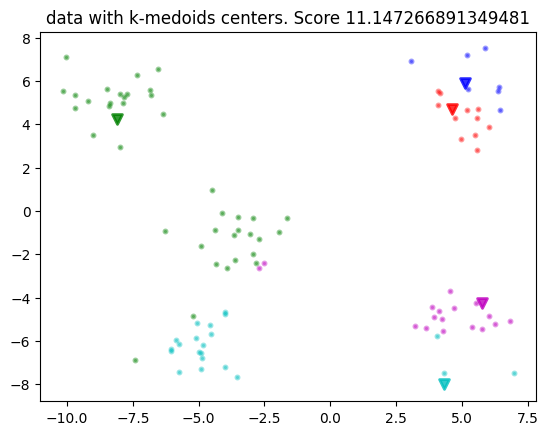

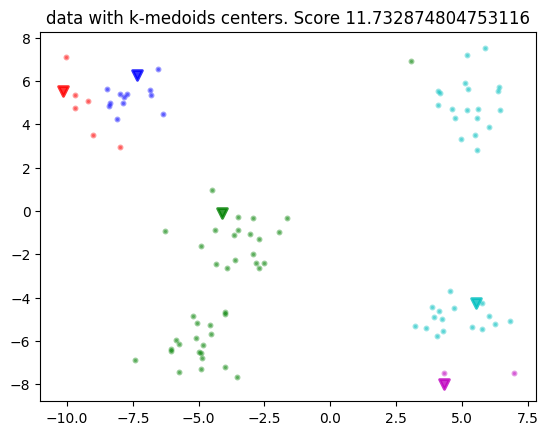

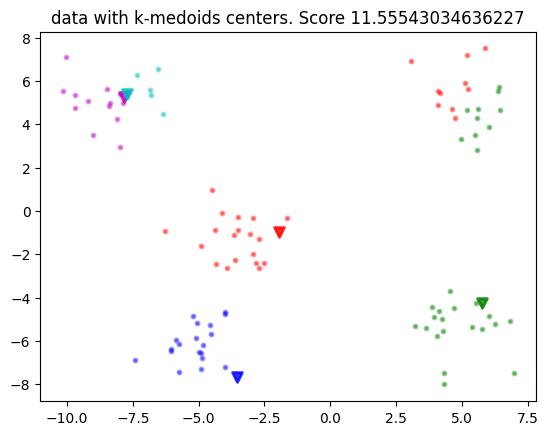

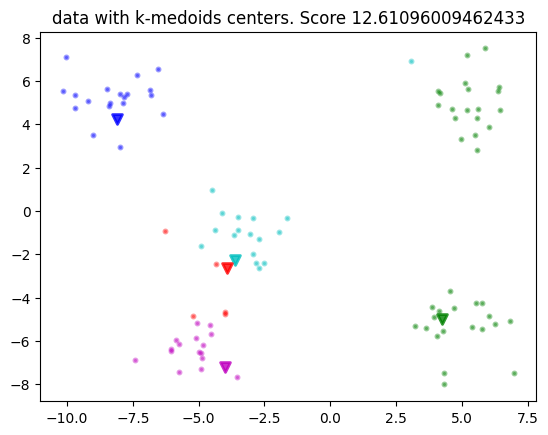

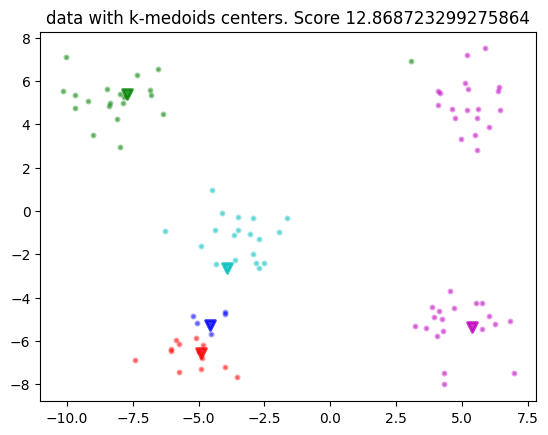

In [120]:
for i in range(5):
    centers = k_medoids(X, k=5)
    plot_data(X, centers, title = f'data with k-medoids centers. Score {score(X, centers)}') 